In [1]:
import sys
sys.path.append("../Modules/")
sys.path.append("../")
import os

import pandas as pd
import numpy as np

from configobj import ConfigObj
from configobj import flatten_errors
from validate import Validator
    
import logging

#fmt = 'logging.Formatter(''%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
fmt = '%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
logging.basicConfig(level=logging.INFO, format=fmt)
logger = logging.getLogger(__name__)


In [2]:
allTrialData = pd.read_pickle('../allTrialData.pickle')
# allTrialData['expansionGain'] = allTrialData['expansionGain'].astype(np.float)
# allTrialData['passingLocX'] = allTrialData['passingLocX'].astype(np.float)

In [3]:
# allTrialData['observedError']

In [4]:
def removeOutliers(allTrialData,columnName,stdRange=3):
    outliers = np.abs(allTrialData[columnName]-allTrialData[columnName].mean()) > (stdRange*allTrialData[columnName].std())
    allTrialData[columnName] = allTrialData[columnName].mask(outliers)
    return allTrialData

# Create an array for matlabby averaging across dimensions 

In [5]:
allTrialData = removeOutliers(allTrialData,'velPredError',2.5)
allTrialData = removeOutliers(allTrialData,'observedError',2.5)

In [6]:
#fixDf_trial_block_sub = allTrialData.groupby(('subjectNumber','trialNumber','blockNumber'))

fixDf_expG_passLoc_bl_sub = allTrialData.groupby(('expansionGain',
                                                  'passingLocX',
                                                  'blockNumber',
                                                  'fileName'))

expansionGainList = list(np.sort(allTrialData.groupby('expansionGain').groups.keys()))
passingLocXList = list(np.sort(allTrialData.groupby('passingLocX').groups.keys()))
blockList = list(allTrialData.groupby('blockNumber').groups.keys())
fileNames = list(allTrialData.groupby('fileName').groups.keys())

numGain = len(expansionGainList)
numPassingLoc = len(passingLocXList)
numBlock = len(blockList)
numSub = len(fileNames)

# Initialize to an array of zeros 
constantVelModel_gain_pass_bl_sub = np.zeros([numGain,numPassingLoc,numBlock, numSub])
observed_gain_pass_bl_sub = np.zeros([numGain,numPassingLoc,numBlock, numSub])

stdConstantVelModel_gain_pass_bl_sub = np.zeros([numGain,numPassingLoc,numBlock, numSub])
stdObserved_gain_pass_bl_sub = np.zeros([numGain,numPassingLoc,numBlock, numSub])

fileNames_sub = []
for (gain,pLoc,bl,sub), data in fixDf_expG_passLoc_bl_sub:
    # Iterate through groups, while keeping track of which group we're in.
    # The tuple (gain,pLoc,bl,sub) contains the group indices
    # The variable data is a dataframe containing rows in that group 
    
    # Convert group indices to numeric indices into their value lists
    # ...what is the index of a gain of 0.5 in the expansionGainList?
    gainIdx  = [i for i, s in enumerate(expansionGainList) if gain == s]
    plocIdx  = [i for i, s in enumerate(passingLocXList) if pLoc == s]  
    blIdx  = [i for i, s in enumerate(blockList) if bl == s]
    subIdx  = [i for i, s in enumerate(fileNames) if sub == s]


    constantVelModel_gain_pass_bl_sub[gainIdx,plocIdx,blIdx,subIdx]  = data['velPredError'].mean()
    observed_gain_pass_bl_sub[gainIdx,plocIdx,blIdx,subIdx]  = data['observedError'].mean()
    
    stdConstantVelModel_gain_pass_bl_sub[gainIdx,plocIdx,blIdx,subIdx]  = data['velPredError'].std()
    stdObserved_gain_pass_bl_sub[gainIdx,plocIdx,blIdx,subIdx]  = data['observedError'].std()
    


# Plot azimuthal lead/lag to ball center

In [7]:
import matplotlib.pyplot as plt
%matplotlib notebook

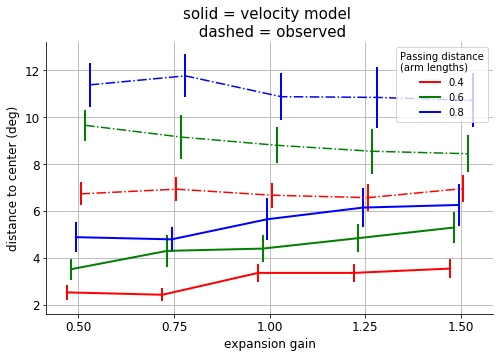

In [8]:
plotSubData = True

##############
nSubs = np.shape(constantVelModel_gain_pass_bl_sub)[3]
meanConstantVel_gain_pass_bl  = np.nanmean(constantVelModel_gain_pass_bl_sub,axis=3)
serConstantVel_gain_pass_bl = np.nanstd(constantVelModel_gain_pass_bl_sub,axis=3) / np.sqrt(nSubs)

meanObserved_gain_pass_bl  = np.nanmean(observed_gain_pass_bl_sub,axis=3)
serObserved_gain_pass_bl = np.nanstd(observed_gain_pass_bl_sub,axis=3) / np.sqrt(nSubs)

p, ax = plt.subplots(1, 1) #sharey=True)

cList = ['r','g','b']
offsets = np.linspace(-.03,.03,6)
# Block 2
for pIdx, pVal in enumerate(passingLocXList):

    x = expansionGainList + offsets[pIdx]
    y = meanConstantVel_gain_pass_bl[:,pIdx,1]
    yerr = serConstantVel_gain_pass_bl[:,pIdx,1]
    h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],fmt="none")
    
    x = expansionGainList + offsets[pIdx+3]
    y = meanObserved_gain_pass_bl[:,pIdx,1]
    yerr = serObserved_gain_pass_bl[:,pIdx,1]
    #h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],
                fmt='-.',color = cList[pIdx])

            
plt.gcf().set_size_inches(8,5)
ax.axes.set_title('solid = velocity model \n dashed = observed', fontsize=15)
ax.set_ylabel('distance to center (deg)', fontsize=12)
ax.set_xlabel('expansion gain', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

#ax.set_ylim([-.1,.4])
plt.legend(title='Passing distance\n(arm lengths)')
ax.axes.spines['top'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
ax.axes.yaxis.grid(True)
ax.axes.xaxis.grid(True)
ax.axes.set_axisbelow(True)

plt.rcParams["font.family"] = "sans-serif"
ax.set_xticks(expansionGainList)
ax.tick_params(axis='both', which='major', labelsize=12)

p.set_facecolor('w')
#plt.savefig('leadLagCenter.png', facecolor=p.get_facecolor(), transparent=True)

###  For a single subject

In [9]:
fixDf_expG_bl_sub = allTrialData.groupby(('expansionGain',
                                          'blockNumber',
                                          'fileName'))

k = fixDf_expG_bl_sub['ballCaughtQ'].groups.keys()
nReps = len(fixDf_expG_bl_sub['ballCaughtQ'].get_group(k[0]))


allTrialData.groupby(('expansionGain','blockNumber')).groups.keys()
pctCaught_expG_passLoc_bl_sub = fixDf_expG_bl_sub['ballCaughtQ'].agg(np.sum)/nReps*100
pctCaughtB2NoExp_fileName = pctCaught_expG_passLoc_bl_sub[0.75,2]

In [10]:
# fileTimeList = [];
# [fileTimeList.append(name) for name in os.listdir("../Data/") if name[0] is not '.'];
# fileTimeList

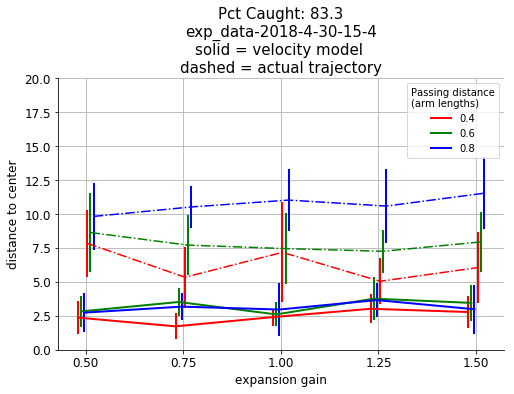

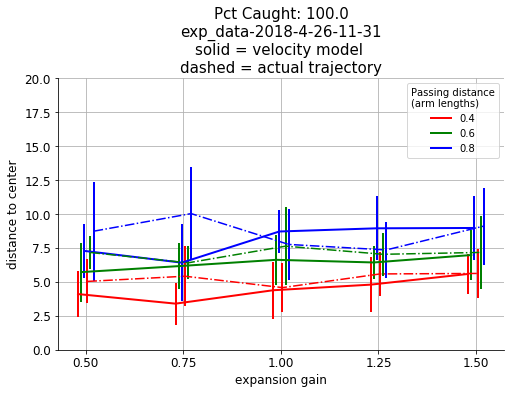

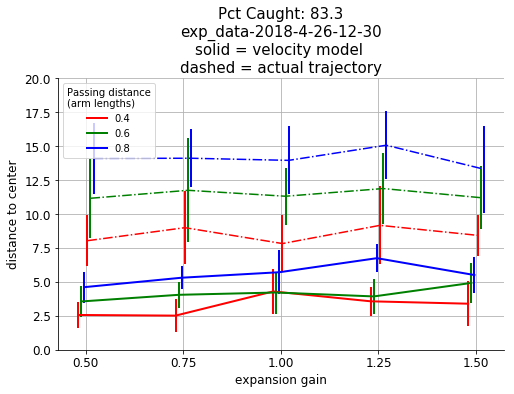

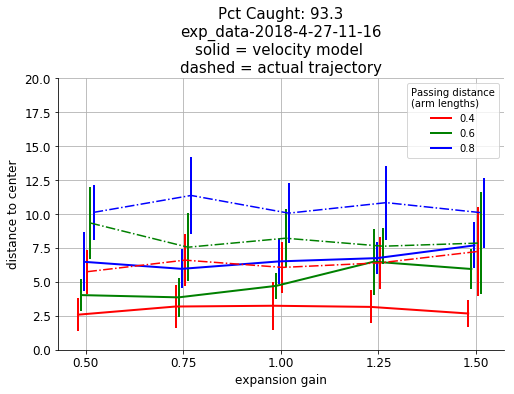

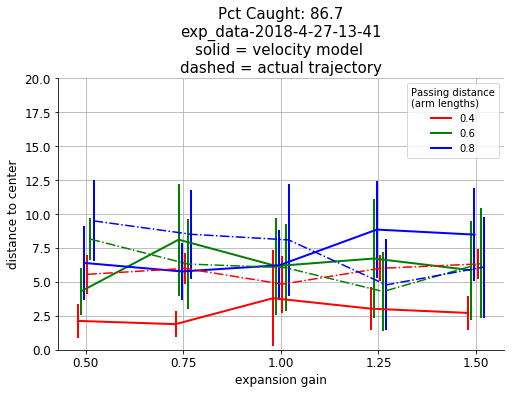

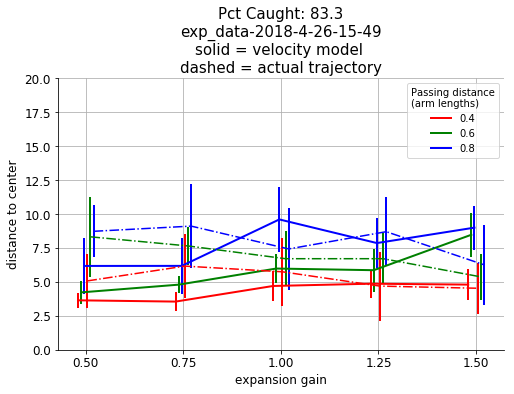

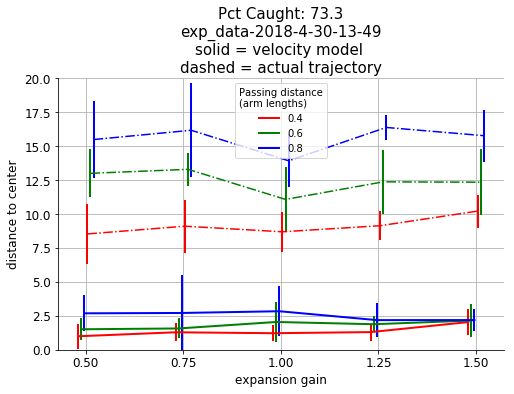

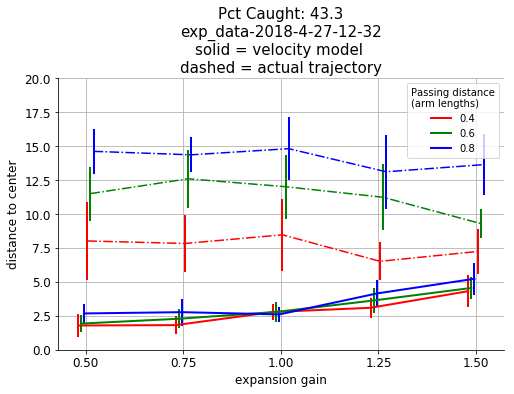

In [11]:

for subIdx in range(np.shape(constantVelModel_gain_pass_bl_sub)[3]):

    ##############
    nSubs = np.shape(constantVelModel_gain_pass_bl_sub)[3]
    meanConstantVel_gain_pass_bl  = np.squeeze(constantVelModel_gain_pass_bl_sub[:,:,:,subIdx])
    stdConstantVel_gain_pass_bl  = np.squeeze(stdConstantVelModel_gain_pass_bl_sub[:,:,:,subIdx])
    #serConstantVel_gain_pass_bl = np.std(constantVelModel_gain_pass_bl_sub[:,:,:,subIdx],axis=3)

    meanObserved_gain_pass_bl  = np.squeeze(observed_gain_pass_bl_sub[:,:,:,subIdx])
    stdObserved_gain_pass_bl  = np.squeeze(stdObserved_gain_pass_bl_sub[:,:,:,subIdx])
    #serObserved_gain_pass_bl = np.std(observed_gain_pass_bl_sub[:,:,:,subIdx],axis=3)

    p, ax = plt.subplots(1, 1) #sharey=True)

    cList = ['r','g','b']
    offsets = np.linspace(-.02,.02,6)
    # Block 2
    for pIdx, pVal in enumerate(passingLocXList):

        x = expansionGainList + offsets[pIdx]
        y = meanConstantVel_gain_pass_bl[:,pIdx,1]
        yerr = stdConstantVel_gain_pass_bl[:,pIdx,1]
        h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
        h.set_label(pVal)
        ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],fmt="none")

        x = expansionGainList + offsets[pIdx+3]
        y = meanObserved_gain_pass_bl[:,pIdx,1]
        yerr = stdObserved_gain_pass_bl[:,pIdx,1]
        
        #h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
        h.set_label(pVal)
        ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],
                    fmt='-.',color = cList[pIdx])


    plt.gcf().set_size_inches(8,5)
    pctCaught = pctCaughtB2NoExp_fileName[fileNames[subIdx]]
    titleStr = 'Pct Caught: {0:.1f}\n{1:}\nsolid = velocity model \ndashed = actual trajectory'.format(pctCaught,fileNames[subIdx])
    ax.axes.set_title(titleStr, fontsize=15)
    #ax.axes.set_title('Pct Caught: ' +  fileNames[subIdx]  + '\nsolid = velocity model \n dashed = actual trajectory', fontsize=15)
    
    ax.set_ylabel('distance to center', fontsize=12)
    ax.set_xlabel('expansion gain', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_ylim([0,20])
    plt.legend(title='Passing distance\n(arm lengths)')
    ax.axes.spines['top'].set_visible(False)
    ax.axes.spines['right'].set_visible(False)
    ax.axes.yaxis.grid(True)
    ax.axes.xaxis.grid(True)
    ax.axes.set_axisbelow(True)

    plt.rcParams["font.family"] = "sans-serif"
    ax.set_xticks(expansionGainList)
    ax.tick_params(axis='both', which='major', labelsize=12)

    #plt.title(fileNames_sub[subIdx])
    p.set_facecolor('w')

    #plt.savefig('leadLagCenter.png', facecolor=p.get_facecolor(), transparent=True)
    
    # solid = velocity model,dashed = accel model